Import necessary libs

In [98]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re

This code connects to a local MongoDB instance, accesses the `PythonForDs` database and the `isw_report` collection, retrieves all documents, and loads them into a Pandas DataFrame.

In [99]:
client = MongoClient("mongodb://localhost:27017/")
db = client["PythonForDs"]
collection = db["isw_report"]
cursor = collection.find()
df = pd.DataFrame(list(cursor))

Basic operations with datasets

In [100]:
df.head()

,_id,date,extracted_text
0,67f568f9dcd7a5c401c30a6b,2022-02-25,Russian forces entered major Ukrainian cities—...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,Russian forces’ main axes of advance in the la...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,The Russian military has likely recognized tha...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,The Russian military is reorganizing its milit...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,Russian forces are completing the reinforcemen...


This cell defines a `clean_text` function that:
- Converts text to lowercase
- Removes digits
- Removes punctuation
- Strips extra spaces

It then applies this function to the `extracted_text` column of the DataFrame, creating a new `cleaned_text` column.

In [101]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['cleaned_text'] = df['extracted_text'].apply(clean_text)

This step downloads the required NLTK tokenizer model (`punkt_tab`) and tokenizes the cleaned text.

In [102]:
nltk.download('punkt_tab')
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


This step downloads the NLTK English stopword list and removes common stopwords (like "the", "and", "is", etc.) from the tokenized text.

In [103]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['no_stopwords'] = df['tokens'].apply(
    lambda words: [word for word in words if word not in stop_words]
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This step downloads the WordNet lemmatizer and applies it to the tokenized, stopword-free text.

Each word in the `no_stopwords` column is lemmatized (i.e., reduced to its base or dictionary form), and the results are stored in a new column called `lemmatized`.

In [104]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['no_stopwords'].apply(
    lambda words: [lemmatizer.lemmatize(word) for word in words]
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Администратор\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [105]:
stemmer = PorterStemmer()
df['stemmed'] = df['no_stopwords'].apply(
    lambda words: [stemmer.stem(word) for word in words]
)

This step converts the list of tokens back into string format:

- `lemmatized_text`: Joins the lemmatized tokens into a single string for each document.
- `stemmed_text`: Joins the stemmed tokens into a single string for each document.

This is useful for further analysis, vectorization (e.g., TF-IDF), or visualization (e.g., word clouds).

In [106]:
df['lemmatized_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))
df['stemmed_text'] = df['stemmed'].apply(lambda x: ' '.join(x))

In [107]:
df.head()

,_id,date,extracted_text,cleaned_text,tokens,no_stopwords,lemmatized,stemmed,lemmatized_text,stemmed_text
0,67f568f9dcd7a5c401c30a6b,2022-02-25,Russian forces entered major Ukrainian cities—...,russian forces entered major ukrainian cities ...,"[russian, forces, entered, major, ukrainian, c...","[russian, forces, entered, major, ukrainian, c...","[russian, force, entered, major, ukrainian, ci...","[russian, forc, enter, major, ukrainian, citi,...",russian force entered major ukrainian city inc...,russian forc enter major ukrainian citi includ...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,Russian forces’ main axes of advance in the la...,russian forces main axes of advance in the las...,"[russian, forces, main, axes, of, advance, in,...","[russian, forces, main, axes, advance, last, h...","[russian, force, main, ax, advance, last, hour...","[russian, forc, main, axe, advanc, last, hour,...",russian force main ax advance last hour focuse...,russian forc main axe advanc last hour focus k...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,The Russian military has likely recognized tha...,the russian military has likely recognized tha...,"[the, russian, military, has, likely, recogniz...","[russian, military, likely, recognized, initia...","[russian, military, likely, recognized, initia...","[russian, militari, like, recogn, initi, expec...",russian military likely recognized initial exp...,russian militari like recogn initi expect limi...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,The Russian military is reorganizing its milit...,the russian military is reorganizing its milit...,"[the, russian, military, is, reorganizing, its...","[russian, military, reorganizing, military, ef...","[russian, military, reorganizing, military, ef...","[russian, militari, reorgan, militari, effort,...",russian military reorganizing military effort ...,russian militari reorgan militari effort attem...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,Russian forces are completing the reinforcemen...,russian forces are completing the reinforcemen...,"[russian, forces, are, completing, the, reinfo...","[russian, forces, completing, reinforcement, r...","[russian, force, completing, reinforcement, re...","[russian, forc, complet, reinforc, resuppli, t...",russian force completing reinforcement resuppl...,russian forc complet reinforc resuppli troop n...


Dropping useless columns

In [108]:
df.drop(["extracted_text", "cleaned_text", "tokens", "no_stopwords", "lemmatized", "stemmed"], axis=1, inplace=True)

Default operations to check dataset one more time:

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123 entries, 0 to 1122
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _id              1123 non-null   object        
 1   date             1123 non-null   datetime64[ns]
 2   lemmatized_text  1123 non-null   object        
 3   stemmed_text     1123 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 35.2+ KB


Visualization of basic parameters:

In [110]:
df_copy = df.copy()

The histogram reveals that the majority of the text lengths in ISW reports range between 15,000 and 25,000 characters. The mean length is slightly higher than the median, indicating a slightly right-skewed distribution. The peak in the histogram around 20,000 characters suggests that most reports are close to this length.

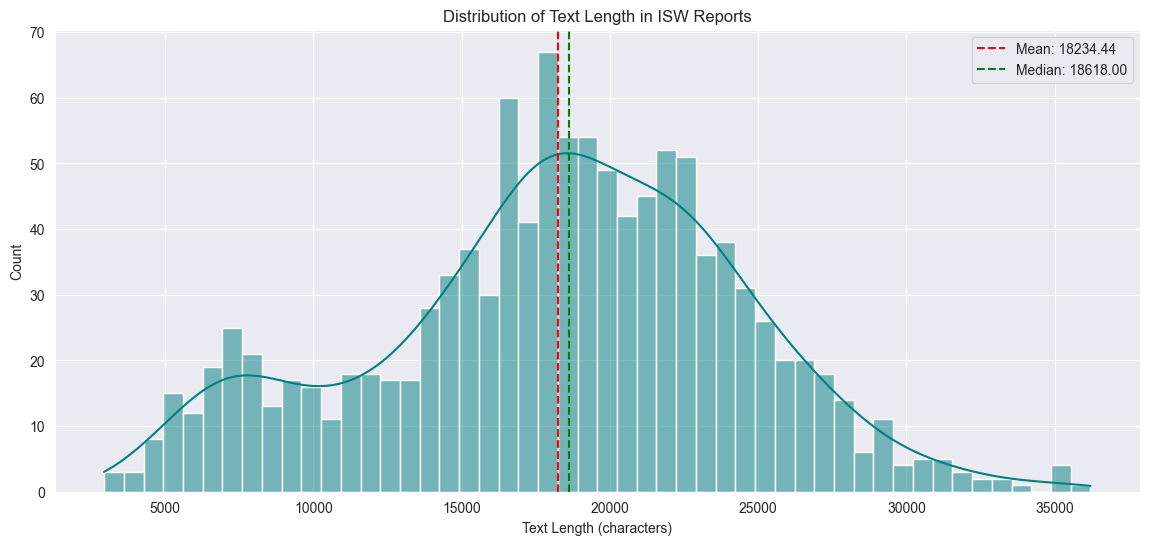

In [111]:
df_copy['text_length'] = df_copy['lemmatized_text'].apply(len)
plt.figure(figsize=(14, 6))
sns.histplot(df_copy['text_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of Text Length in ISW Reports')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.axvline(df_copy['text_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_copy["text_length"].mean():.2f}')
plt.axvline(df_copy['text_length'].median(), color='green', linestyle='--',
            label=f'Median: {df_copy["text_length"].median():.2f}')
plt.legend();

Working with text:

In [112]:
df_copy['text_length'] = df_copy['lemmatized_text'].apply(len)
df_copy['word_count'] = df_copy['lemmatized_text'].apply(lambda x: len(str(x).split()))

# Text length statistics
print("\nText length statistics:")
print(f"Mean text length: {df_copy['text_length'].mean():.2f} characters")
print(f"Median text length: {df_copy['text_length'].median():.2f} characters")
print(f"Min text length: {df_copy['text_length'].min()} characters")
print(f"Max text length: {df_copy['text_length'].max()} characters")
print(f"Mean word count: {df_copy['word_count'].mean():.2f} words")
print(f"Median word count: {df_copy['word_count'].median():.2f} words")


Text length statistics:
Mean text length: 18234.44 characters
Median text length: 18618.00 characters
Min text length: 2937 characters
Max text length: 36212 characters
Mean word count: 2281.53 words
Median word count: 2324.00 words


Just the same graph, but with wordds instead of text:

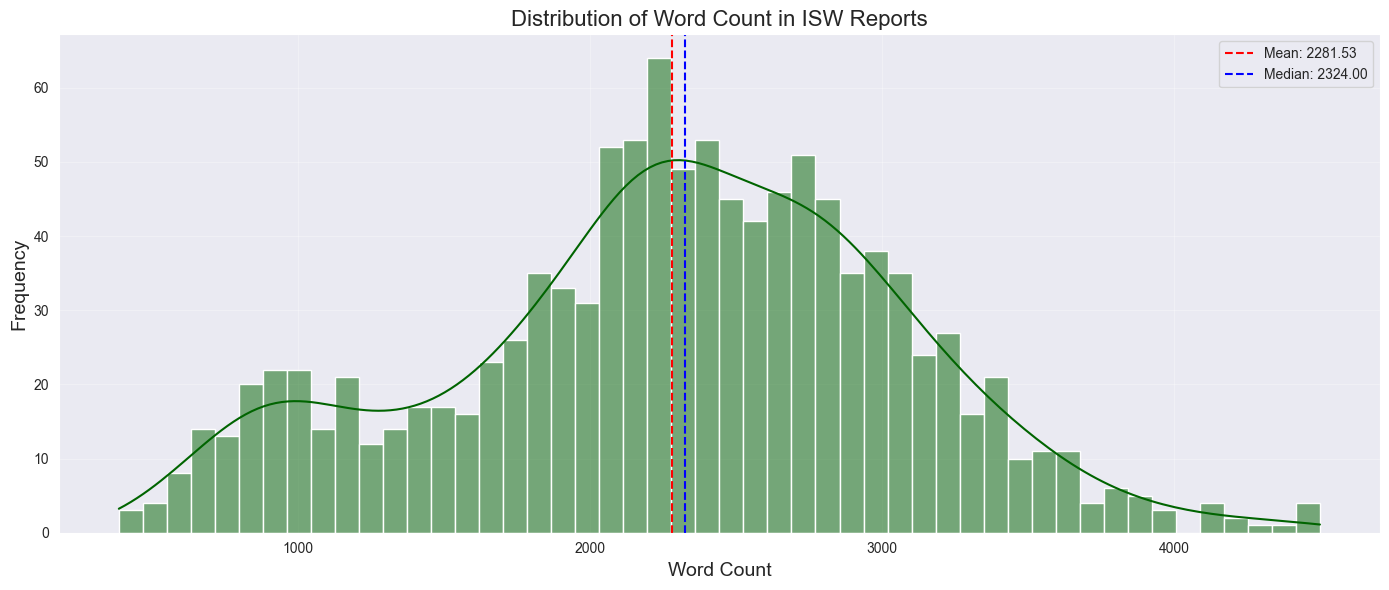

In [113]:
plt.figure(figsize=(14, 6))
sns.histplot(df_copy['word_count'], bins=50, kde=True, color='darkgreen')
plt.title('Distribution of Word Count in ISW Reports', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(df_copy['word_count'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_copy["word_count"].mean():.2f}')
plt.axvline(df_copy['word_count'].median(), color='blue', linestyle='--',
            label=f'Median: {df_copy["word_count"].median():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

During this stage of text processing, we noticed that the number of ISW reports was significantly lower in the first few months of the dataset.

This observation revealed two key insights:
- Our initial ISW scraping script was missing some early reports.
- Reports at the beginning of the war tend to be shorter and less detailed.

To address the missing data, we updated and re-ran our ISW scraper to improve coverage, especially for the early months of the war.

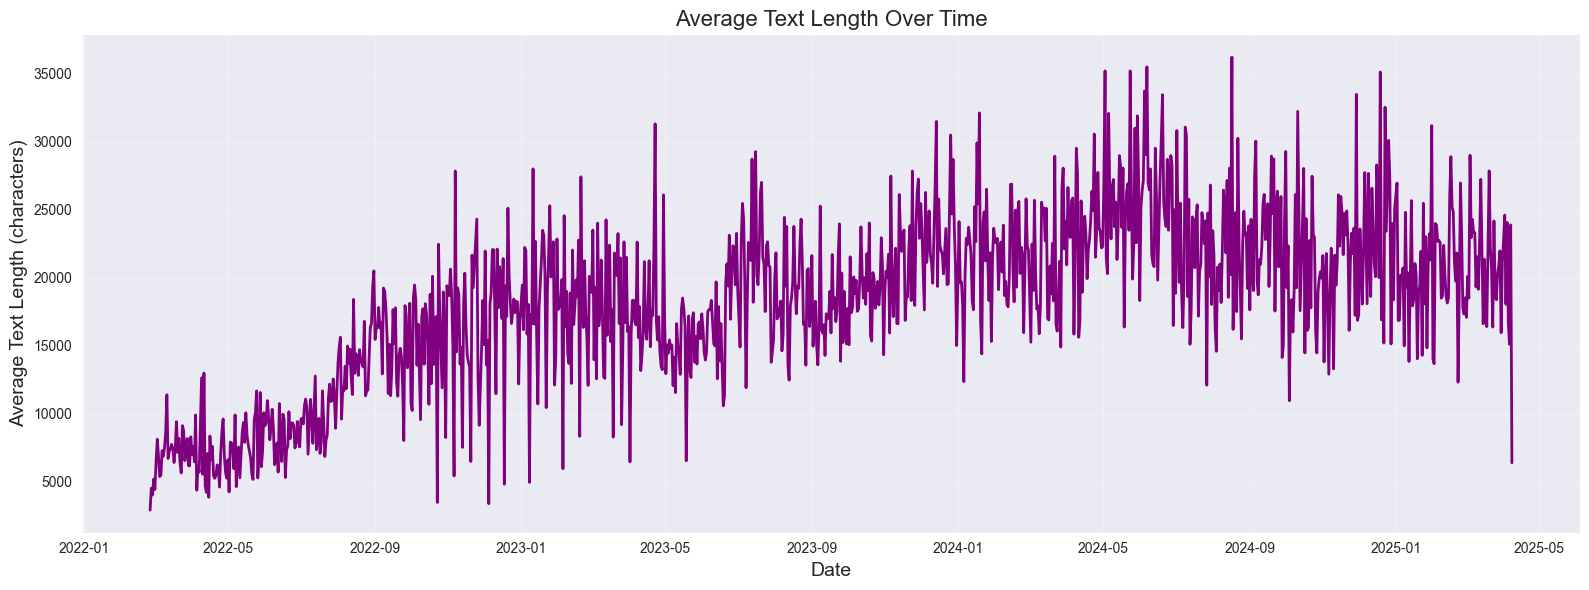

In [114]:
plt.figure(figsize=(16, 6))
text_length_by_date = df_copy.groupby(df_copy['date'].dt.date)['text_length'].mean()
text_length_by_date.plot(color='purple', linewidth=2)
plt.title('Average Text Length Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Text Length (characters)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this phase, we refined our text cleaning pipeline with additional filtering:

- **Removed special characters** and retained only alphabetic characters.
- **Lowercased all text** for consistency.
- **Filtered out short tokens** (1–2 letters) that typically carry little meaning.
- **Removed English stopwords** using NLTK's `stopwords` list.
- **Excluded month names**, which were frequently appearing in reports but added little value to the textual analysis.


In [116]:
stop_words = set(stopwords.words('english'))

In [117]:
months = {
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december'
}


def clean_lemmed_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and word not in months]

    return ' '.join(tokens)

In [118]:
df['lem_text_clean'] = df['lemmatized_text'].apply(clean_lemmed_text)


In [119]:
df.head()

,_id,date,lemmatized_text,stemmed_text,lem_text_clean
0,67f568f9dcd7a5c401c30a6b,2022-02-25,russian force entered major ukrainian city inc...,russian forc enter major ukrainian citi includ...,russian force entered major ukrainian city inc...
1,67f568f9dcd7a5c401c30a6c,2022-02-26,russian force main ax advance last hour focuse...,russian forc main axe advanc last hour focus k...,russian force main advance last hour focused k...
2,67f568f9dcd7a5c401c30a6d,2022-02-27,russian military likely recognized initial exp...,russian militari like recogn initi expect limi...,russian military likely recognized initial exp...
3,67f568f9dcd7a5c401c30a6e,2022-02-28,russian military reorganizing military effort ...,russian militari reorgan militari effort attem...,russian military reorganizing military effort ...
4,67f568f9dcd7a5c401c30a6f,2022-03-01,russian force completing reinforcement resuppl...,russian forc complet reinforc resuppli troop n...,russian force completing reinforcement resuppl...


In this step, we focused on further refining the text data by removing any additional **useless words** that were not contributing to the analysis. This is an important part of preparing the data for more accurate feature extraction and model training.

Once the unnecessary words were dropped, we began preparing the cleaned data for merging with other relevant datasets (weather, alarms) to enrich our analysis and predictions.

This process ensures that only the most relevant information is included in the final dataset, which will be used for training and prediction tasks.

In [120]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=3,  #if word in <=3 docs
    max_df=0.9,  #words that used a lot
)

In [121]:
X_tfidf = vectorizer.fit_transform(df['lem_text_clean'])

In [122]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf['date'] = df['date'].values

We then applied TF-IDF vectorization to the cleaned text using the following configuration:
- `max_features=1000`: Keep only the top 1000 most informative terms.
- `min_df=3`: Ignore words that appear in fewer than 3 documents.
- `max_df=0.9`: Ignore extremely frequent words that appear in more than 90% of documents.

The TF-IDF matrix was converted into a new DataFrame (`df_tfidf`) and augmented with the original `date` column to maintain temporal alignment.

This structured and cleaned dataset is now ready for deeper analysis, modeling, or merging with other features: weather and alarm data.

In [123]:
df_tfidf

,ability,able,access,accused,achieve,acknowledged,across,action,active,actor,...,yar,year,yet,yevgeny,york,youth,zaporizhzhia,zelensky,znpp,zone
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.040400,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.052553,0.0,...,0.000000,0.000000,0.129140,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.048976,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.052185,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.065141,0.034478,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.046576,0.0,0.000000,0.000000,0.042389,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,0.038432,0.027122,0.00000,0.000000,0.058150,0.0,0.000000,0.000000,0.000000,0.0,...,0.162275,0.000000,0.014450,0.0,0.0,0.00000,0.017458,0.000000,0.000000,0.016601
1119,0.020254,0.010720,0.01546,0.013091,0.000000,0.0,0.034047,0.010855,0.013945,0.0,...,0.093295,0.000000,0.011423,0.0,0.0,0.00000,0.027602,0.050814,0.000000,0.013124
1120,0.014538,0.000000,0.00000,0.000000,0.021997,0.0,0.000000,0.000000,0.000000,0.0,...,0.167417,0.015201,0.016398,0.0,0.0,0.00000,0.000000,0.091185,0.000000,0.018840
1121,0.029449,0.015587,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.067825,0.000000,0.016608,0.0,0.0,0.00000,0.000000,0.055412,0.000000,0.000000


We evaluated the sparsity of the TF-IDF matrix to understand how many values are actually zero. This is important because TF-IDF representations tend to be sparse, especially in large text corpora.

The calculation is based on:
- `nonzero`: Total number of non-zero entries in the matrix.
- `total`: Total number of elements in the matrix.
- `sparsity`: The proportion of elements that are zero.

A high sparsity value (close to 1) indicates that most of the TF-IDF matrix consists of zeros, which is expected in text data and helps guide future decisions for dimensionality reduction or model choice.


In [153]:
nonzero = X_tfidf.nnz
total = X_tfidf.shape[0] * X_tfidf.shape[1]
sparsity = 1 - (nonzero / total)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.6082


### Sparsity of the TF-IDF Matrix

We evaluated the sparsity of the TF-IDF matrix, which measures the proportion of zero entries in the matrix.

This level of sparsity suggests that many terms do not appear frequently across the corpus, and the majority of terms are unique to specific documents. 

While sparsity is expected in text data, this value can help us decide whether dimensionality reduction techniques (like PCA), so we decided to do it later



Default checking set, looks great, without suspicious words 

In [125]:
word_sums = np.asarray(X_tfidf.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

word_df = pd.DataFrame({'word': words, 'tfidf_sum': word_sums})
word_df = word_df.sort_values(by='tfidf_sum', ascending=False)

print(word_df.head(20))

            word   tfidf_sum
85       bakhmut  107.213694
260        drone   94.297305
543   milblogger   89.497674
706        putin   81.841726
16      advanced   80.490060
272      element   77.721173
80      avdiivka   76.499875
839    southwest   69.303049
551          mod   67.214872
968       wagner   65.145969
544  milbloggers   64.484813
755        rifle   63.153235
115      brigade   62.781740
548      missile   62.616873
556    motorized   62.425092
606    operating   59.260159
719     recently   55.195896
465     kreminna   54.850701
595   occupation   54.376875
78     authority   53.830749


Adding date column to dataset for merging

In [126]:
if len(df_tfidf) == len(df):
    df_tfidf['day_datetime'] = df['date'].values
else:
    print("error")
df.drop("date", axis=1, inplace=True)

check if all good

In [127]:
df_tfidf.head(50)

,ability,able,access,accused,achieve,acknowledged,across,action,active,actor,...,year,yet,yevgeny,york,youth,zaporizhzhia,zelensky,znpp,zone,day_datetime
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-25
1,0.000000,0.040400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052553,0.000000,...,0.000000,0.129140,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-26
2,0.000000,0.048976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.052185,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-27
3,0.065141,0.034478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-28
4,0.000000,0.000000,0.000000,0.000000,0.046576,0.000000,0.000000,0.000000,0.042389,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-03-01
5,0.000000,0.000000,0.000000,0.000000,0.039850,0.000000,0.000000,0.000000,0.036267,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-03-02
6,0.000000,0.000000,0.000000,0.000000,0.144277,0.037171,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.029903,0.000000,0.000000,2022-03-03
7,0.080089,0.056520,0.000000,0.000000,0.000000,0.000000,0.059834,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.180355,0.000000,2022-03-04
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087413,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-03-05
9,0.030156,0.031922,0.000000,0.000000,0.045627,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.034013,0.00000,0.000000,0.000000,0.000000,0.075655,0.000000,0.000000,2022-03-06


In this step, we expand the original dataset (`df_tfidf`) by creating entries for every hour of the day for each report. This is done in the following way:

1. **Date Extraction:** For each row in the DataFrame, we extract the `day_datetime` and convert it to a `datetime` object.
2. **Hour Iteration:** For each day, we generate 24 new entries — one for each hour — by replacing the hour in the `day_datetime`.
3. **Row Duplication:** The new date-time values are added to the row, and a new entry is created for each hour.
4. **Concatenation:** The new rows are concatenated into a new DataFrame (`result_df`).

Finally, the DataFrame is:
- Sorted by `day_datetime` to ensure proper chronological order.
- Reset the index to start from 0, eliminating any gaps from previous concatenation.

This process allows us to have hourly granularity for the reports, enabling a more detailed analysis in subsequent steps.

In [128]:
import datetime

df_tfidf['datetime'] = df_tfidf['day_datetime'].dt.normalize()
df_tfidf.drop("day_datetime", axis=1, inplace=True)
df_tfidf["tommorrow"] = df_tfidf['datetime'].apply(lambda x: x + datetime.timedelta(days=1))

In [129]:
df_tfidf.head()

,ability,able,access,accused,achieve,acknowledged,across,action,active,actor,...,yet,yevgeny,york,youth,zaporizhzhia,zelensky,znpp,zone,datetime,tommorrow
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25,2022-02-26
1,0.000000,0.040400,0.0,0.0,0.000000,0.0,0.0,0.0,0.052553,0.0,...,0.129140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-26,2022-02-27
2,0.000000,0.048976,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.052185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-27,2022-02-28
3,0.065141,0.034478,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-28,2022-03-01
4,0.000000,0.000000,0.0,0.0,0.046576,0.0,0.0,0.0,0.042389,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-03-01,2022-03-02


In [130]:
isw_dict = df_tfidf.to_dict('records')
isw_dict[0]

{'ability': 0.0,
 'able': 0.0,
 'access': 0.0,
 'accused': 0.0,
 'achieve': 0.0,
 'acknowledged': 0.0,
 'across': 0.0,
 'action': 0.0,
 'active': 0.0,
 'actor': 0.0,
 'adaptation': 0.0,
 'added': 0.0,
 'additional': 0.09051771865165115,
 'additionally': 0.0,
 'address': 0.0,
 'administration': 0.0,
 'advanced': 0.0,
 'advancing': 0.18416119086899216,
 'advantage': 0.0,
 'advisor': 0.0,
 'affair': 0.0,
 'affiliated': 0.0,
 'africa': 0.0,
 'agency': 0.0,
 'agreement': 0.0,
 'ahead': 0.0,
 'aid': 0.0,
 'aim': 0.0,
 'aimed': 0.0,
 'air': 0.07416867836655833,
 'airborne': 0.04492026731162778,
 'aircraft': 0.0,
 'airfield': 0.0,
 'airspace': 0.0,
 'akhmat': 0.0,
 'alexander': 0.0,
 'alleged': 0.0,
 'allow': 0.0,
 'allowing': 0.0,
 'almost': 0.0,
 'already': 0.0,
 'although': 0.0,
 'amid': 0.0,
 'ammunition': 0.0,
 'among': 0.0,
 'amplified': 0.0,
 'andriivka': 0.0,
 'annexation': 0.0,
 'annexed': 0.0,
 'announced': 0.0,
 'announcement': 0.0,
 'another': 0.0,
 'anti': 0.0,
 'appeal': 0.0,
 'a

In this step, we expand the ISW reports to a finer hourly granularity

This process allows us to merge the ISW reports on an hourly basis, making it easier to correlate with other time-sensitive data (weather or alarms).

In [131]:
isw_by_hour = []

for isw in isw_dict:
    start_date = pd.Timestamp(isw["datetime"]).normalize()
    end_date = pd.Timestamp(isw["tommorrow"]).normalize()

    for hour in pd.date_range(start=start_date, end=end_date, freq="1h", inclusive="left"):
        hourly_record = isw.copy()
        hourly_record["hour_time"] = hour
        isw_by_hour.append(hourly_record)

isw_hourly_df = pd.DataFrame(isw_by_hour)

In [132]:
isw_hourly_df.shape

(26952, 1003)

In [133]:
isw_hourly_df.select_dtypes(exclude=['number']).columns.tolist()

['date', 'datetime', 'tommorrow', 'hour_time']

In [134]:
isw_hourly_df.drop(["date", "datetime", "tommorrow"], axis=1, inplace=True)

In [135]:
isw_hourly_df.head()

,ability,able,access,accused,achieve,acknowledged,across,action,active,actor,...,year,yet,yevgeny,york,youth,zaporizhzhia,zelensky,znpp,zone,hour_time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25 00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25 01:00:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25 02:00:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25 03:00:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-02-25 04:00:00


In this step, we perform Principal Component Analysis (PCA) on the ISW reports to reduce the dimensionality of the feature set:

1. **Data Preparation**: We drop the `hour_time` column from the dataset to focus on the feature columns.
2. **PCA Application**: We apply PCA to reduce the dimensionality of the dataset to 300 components and then extract the first two principal components (`PC1` and `PC2`) for visualization.
3. **Hour Feature**: The `hour` component is extracted from the `hour_time` column and added to the PCA DataFrame for color-coding based on the hour of the day.

The result is visualized in a **scatter plot**, where the data points are colored by hour, helping us observe any temporal patterns or clustering in the data.

This analysis enables us to see the main variance in the ISW reports, with the most important features captured in the first two components.

- **X-axis**: First principal component (PC1).
- **Y-axis**: Second principal component (PC2).
- **Hue**: Hour of the day, providing insights into temporal trends.

The plot offers a clear view of how the reports vary across different times of the day.

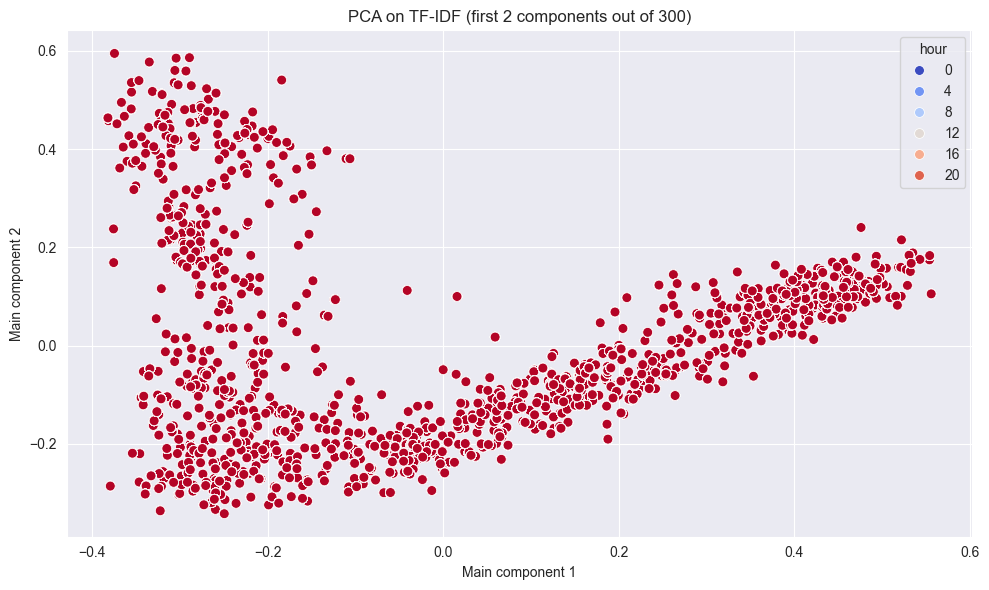

In [149]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df = isw_hourly_df.copy()
df_features = df.drop(columns=['hour_time'])

pca = PCA(n_components=300)
X_pca = pca.fit_transform(df_features)

pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['hour'] = pd.to_datetime(df['hour_time']).dt.hour

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hour', palette='coolwarm', s=50)
plt.title("PCA on TF-IDF (first 2 components out of 300)")
plt.xlabel("Main component 1")
plt.ylabel("Main component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



After applying PCA, we evaluate how much variance each principal component explains in the dataset.

- **Explained Variance Ratio**: This value tells us how much of the total variance in the data is captured by each principal component.
- The sum of the explained variance ratios gives us the overall proportion of the variance explained by the selected components.

In this case, we printed the total explained variance from the first 300 principal components.

The printed output  indicates the proportion of the total variance in the dataset that is explained by the first 300 principal components.

This information helps us assess how well the PCA transformation captures the underlying structure of the data and whether dimensionality reduction is effective.

In [146]:
explained = pca.explained_variance_ratio_
print(f"Summary explaines: {explained.sum():.2%}")


Summary explaines: 86.78%


In [152]:
X_pca

array([[-0.16076573,  0.30795834, -0.03013066, ..., -0.0037619 ,
         0.06659077,  0.01711145],
       [-0.16076573,  0.30795834, -0.03013066, ..., -0.0037619 ,
         0.06659077,  0.01711145],
       [-0.16076573,  0.30795834, -0.03013066, ..., -0.0037619 ,
         0.06659077,  0.01711145],
       ...,
       [ 0.48679592,  0.11659617,  0.13695556, ...,  0.01251163,
        -0.02753308,  0.01669051],
       [ 0.48679592,  0.11659617,  0.13695556, ...,  0.01251163,
        -0.02753308,  0.01669051],
       [ 0.48679592,  0.11659617,  0.13695556, ...,  0.01251163,
        -0.02753308,  0.01669051]], shape=(26952, 300))

We converted `X_pca`, which is a NumPy array, into a DataFrame

In [158]:
X_pca_df = pd.DataFrame(X_pca)

In [160]:
print(X_pca_df.index)
print(isw_hourly_df.index)

RangeIndex(start=0, stop=26952, step=1)
RangeIndex(start=0, stop=26952, step=1)


Added column "hour_time" for merging

In [161]:
X_pca_df["hour_time"] = isw_hourly_df["hour_time"].values

In [162]:
X_pca_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,hour_time
0,-0.160766,0.307958,-0.030131,0.355778,0.138095,-0.310925,0.016864,-0.060866,-0.088998,-0.121990,...,-0.012927,0.009068,0.008995,-0.003598,-0.022087,-0.014706,-0.003762,0.066591,0.017111,2022-02-25 00:00:00
1,-0.160766,0.307958,-0.030131,0.355778,0.138095,-0.310925,0.016864,-0.060866,-0.088998,-0.121990,...,-0.012927,0.009068,0.008995,-0.003598,-0.022087,-0.014706,-0.003762,0.066591,0.017111,2022-02-25 01:00:00
2,-0.160766,0.307958,-0.030131,0.355778,0.138095,-0.310925,0.016864,-0.060866,-0.088998,-0.121990,...,-0.012927,0.009068,0.008995,-0.003598,-0.022087,-0.014706,-0.003762,0.066591,0.017111,2022-02-25 02:00:00
3,-0.160766,0.307958,-0.030131,0.355778,0.138095,-0.310925,0.016864,-0.060866,-0.088998,-0.121990,...,-0.012927,0.009068,0.008995,-0.003598,-0.022087,-0.014706,-0.003762,0.066591,0.017111,2022-02-25 03:00:00
4,-0.160766,0.307958,-0.030131,0.355778,0.138095,-0.310925,0.016864,-0.060866,-0.088998,-0.121990,...,-0.012927,0.009068,0.008995,-0.003598,-0.022087,-0.014706,-0.003762,0.066591,0.017111,2022-02-25 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26947,0.486796,0.116596,0.136956,0.015415,-0.064643,0.031266,0.193600,0.166688,-0.045160,0.011119,...,-0.000145,0.006583,0.012184,-0.016655,0.006878,-0.019462,0.012512,-0.027533,0.016691,2025-04-07 19:00:00
26948,0.486796,0.116596,0.136956,0.015415,-0.064643,0.031266,0.193600,0.166688,-0.045160,0.011119,...,-0.000145,0.006583,0.012184,-0.016655,0.006878,-0.019462,0.012512,-0.027533,0.016691,2025-04-07 20:00:00
26949,0.486796,0.116596,0.136956,0.015415,-0.064643,0.031266,0.193600,0.166688,-0.045160,0.011119,...,-0.000145,0.006583,0.012184,-0.016655,0.006878,-0.019462,0.012512,-0.027533,0.016691,2025-04-07 21:00:00
26950,0.486796,0.116596,0.136956,0.015415,-0.064643,0.031266,0.193600,0.166688,-0.045160,0.011119,...,-0.000145,0.006583,0.012184,-0.016655,0.006878,-0.019462,0.012512,-0.027533,0.016691,2025-04-07 22:00:00


Saving final file for merging

In [146]:
X_pca_df.to_csv("../prepared_data/isw_prepared.csv", index=False)